
# Harvard-GF — Inference + Visualization (TDS, 52 points)

This notebook runs **inference** with your trained backbone (**ViT** or **DINOv3-ConvNeXt**) and renders **52-point TDS** visualizations similar to the paper figure (Input | Ground truth | Prediction).  
It also **exports** predictions and targets to Excel.


In [3]:
import os
print(os.getcwd()) 

/mnt/sda/sijiali/GlaucomaCode


## Config

In [4]:
import os, json, math
from pathlib import Path
from typing import List, Optional

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch import nn
import timm

# Project utilities (must exist in your repo)
from dataset import HarvardGFDataset
from utils import get_vit_transform, get_cnn_transform, get_albumentations_transform, get_imagenet_transform

# HF model for DINOv3
from transformers import AutoModel

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize

from dino_model import DinoV3Backbone52


# ==== Config ====
# Paths
hgf_dir = '/mnt/sda/sijiali/DataSet/Harvard-GF/Dataset/Test'   # dir with .npz
weight_path = '/mnt/sda/sijiali/GlaucomaCode/Results_HGF/dinov3/dinov3_imagenet_lr5e-3/ckpts/best_model_epoch_18_rmse_5.7145.pth'
out_dir = './Results_visualization'
pred_filename = 'test_pred.xlsx'
tar_filename  = 'test_tar.xlsx'

# Model
backbone = 'dinov3'  # 'vit' or 'dinov3'
hf_model_name = '/mnt/sda/sijiali/GlaucomaCode/pretrained_weight/dinov3-vitb16-pretrain-lvd1689m'  # used when backbone='dinov3'
vit_pool = 'mean_patch'  # 'cls' or 'mean_patch'; used when backbone='dinov3'
device = 'cuda'

# Data / transforms
modality_type = 'rnflt'
task = 'tds'
resolution = 224
depth = 3
transform_name = 'vit'   # 'vit' | 'cnn' | 'albumentations' | 'none' | 'imagenet'

# Subset selection
mode = 'first_n'  # 'first_n' or 'ids'
n = 6             # only used when mode='first_n'
ids = ''          # comma-separated; used when mode='ids'
ids_file = ''     # a file with one id per line; used when mode='ids'

# Inference params
batch_size = 1
num_workers = 4
clamp = False

# Scale (IMPORTANT): if you trained with labels/10, keep scale=10.0 so we multiply predictions back.
scale = 10.0


## Functions

In [5]:

# ==== Helpers: list/pick ids ====
def list_all_ids(hgf_dir: str) -> List[str]:
    ids = sorted([Path(f).stem for f in os.listdir(hgf_dir) if f.endswith('.npz')])
    if not ids:
        raise RuntimeError(f'No .npz files found in {hgf_dir}')
    return ids

def pick_ids(hgf_dir: str, mode: str, n: int = 0, ids: Optional[List[str]] = None) -> List[str]:
    all_ids = list_all_ids(hgf_dir)
    if mode == 'first_n':
        assert n > 0, 'n must be > 0 for mode=first_n'
        return all_ids[:n]
    elif mode == 'ids':
        assert ids and len(ids) > 0, 'mode=ids requires ids'
        aset = set(all_ids)
        return [i for i in ids if i in aset]
    else:
        raise ValueError(f'Unknown mode: {mode}')


In [6]:

# ==== Build target DataFrame from .npz ====
def build_tar_df_from_npz(hgf_dir: str, picked_ids: List[str], lat_fill: str = 'Unknown') -> pd.DataFrame:
    vecs = []
    for sid in picked_ids:
        npz_path = os.path.join(hgf_dir, f'{sid}.npz')
        raw = np.load(npz_path, allow_pickle=True)
        if 'tds' not in raw.files:
            raise KeyError(f"'tds' not in {npz_path}, keys={raw.files}")
        vecs.append(raw['tds'].astype(np.float32))
    mat = np.stack(vecs, axis=0)  # (N,K)
    cols = [f'tar_{i}' for i in range(mat.shape[1])]
    df = pd.DataFrame(mat, columns=cols)
    df.insert(0, 'test_id', picked_ids)
    df.insert(1, 'test_lat', [lat_fill] * len(picked_ids))
    return df


In [7]:

# ==== Sequential sampler on specific indices ====
class SeqOnIndices(torch.utils.data.Sampler):
    def __init__(self, indices: List[int]):
        self.indices = indices
    def __iter__(self):
        return iter(self.indices)
    def __len__(self):
        return len(self.indices)

# ==== DataLoader subset ====
def get_hgf_loader_subset(
    hgf_dir: str,
    modality_type: str,
    task: str,
    resolution: int,
    depth: int,
    transform,
    picked_ids: List[str],
    batch_size: int = 1,
    num_workers: int = 4,
) -> DataLoader:
    ds = HarvardGFDataset(
        data_path=hgf_dir,
        modality_type=modality_type,
        task=task,
        resolution=resolution,
        depth=depth,
        transform=transform,
    )
    id2idx = {Path(f).stem: i for i, f in enumerate(ds.files)}
    indices = [id2idx[s] for s in picked_ids if s in id2idx]
    sampler = SeqOnIndices(indices)
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        sampler=sampler,
        pin_memory=True,
    )


In [8]:

# ==== 52-point layout & visualization ====
HARVARD_GF_52_LAYOUT = [
    [None,  0,  1,  2,  3,  4,  5, None],
    [  6,   7,  8,  9, 10, 11, 12, 13],
    [ 14,  15, 16, 17, 18, 19, 20, 21],
    [ 22,  23, 24, 25, 26, 27, 28, 29],
    [ 30,  31, 32, 33, 34, 35, 36, 37],
    [ 38,  39, 40, 41, 42, 43, 44, 45],
    [None, 46, 47, 48, 49, 50, 51, None],
]

def _draw_vf(ax, values, layout=HARVARD_GF_52_LAYOUT, vmin=None, vmax=None,
             cmap='gray', fontsize=8, fmt='{:.1f}'):
    values = np.asarray(values).reshape(-1)
    assert values.size == 52, f'Expect 52 values, got {values.size}'
    if vmin is None: vmin = float(np.nanmin(values))
    if vmax is None: vmax = float(np.nanmax(values))
    norm = Normalize(vmin=vmin, vmax=vmax)
    ax.set_aspect('equal'); ax.axis('off')
    n_rows, n_cols = len(layout), len(layout[0])
    for r in range(n_rows):
        for c in range(n_cols):
            idx = layout[r][c]
            if idx is None: continue
            v = float(values[idx])
            rect = Rectangle((c, r), 1, 1, facecolor=plt.get_cmap(cmap)(norm(v)),
                             edgecolor='k', linewidth=0.5)
            ax.add_patch(rect)
            lum = norm(v)
            txt_color = 'white' if lum < 0.4 else 'black'
            ax.text(c+0.5, r+0.5, fmt.format(v), ha='center', va='center',
                    fontsize=fontsize, color=txt_color)
    ax.set_xlim(0, n_cols); ax.set_ylim(n_rows, 0)

def plot_vf_triptych(input_img, gt_52, pred_52, layout=HARVARD_GF_52_LAYOUT,
                     vmin=None, vmax=None, save_path=None, titles=('Input','Ground truth','Prediction')):
    gt_52  = np.asarray(gt_52).reshape(-1)
    pred_52 = np.asarray(pred_52).reshape(-1)
    if vmin is None: vmin = float(np.nanmin([gt_52.min(), pred_52.min()]))
    if vmax is None: vmax = float(np.nanmax([gt_52.max(), pred_52.max()]))
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), gridspec_kw={'width_ratios':[1.2,1,1]})
    # Input
    ax0 = axes[0]; ax0.axis('off'); ax0.set_title(titles[0])
    img = input_img
    if torch.is_tensor(img): img = img.detach().cpu().numpy()
    if img.ndim == 3 and img.shape[0] in (1,3): img = np.transpose(img, (1,2,0))
    if img.ndim == 2: ax0.imshow(img, cmap='gray')
    else: ax0.imshow(np.clip(img, 0, 1))
    # GT & Pred
    axes[1].set_title(titles[1]); _draw_vf(axes[1], gt_52, layout, vmin, vmax)
    axes[2].set_title(titles[2]); _draw_vf(axes[2], pred_52, layout, vmin, vmax)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=200); plt.close(fig)
    else: plt.show()

def preview_layout(layout=HARVARD_GF_52_LAYOUT):
    dummy = np.arange(52)
    fig, ax = plt.subplots(figsize=(4,4))
    _draw_vf(ax, dummy, layout, vmin=0, vmax=51, fmt='{:.0f}')
    ax.set_title('Index layout (0..51)'); plt.tight_layout(); plt.show()


## Infer

In [9]:

# ==== Build model, DataLoader, run inference, export ====
# 1) Pick IDs
if mode == 'first_n':
    picked_ids = pick_ids(hgf_dir, 'first_n', n=n)
else:
    id_list = []
    if ids:      id_list += [s.strip() for s in ids.split(',') if s.strip()]
    if ids_file:
        with open(ids_file, 'r') as f:
            id_list += [line.strip() for line in f if line.strip()]
    picked_ids = pick_ids(hgf_dir, 'ids', ids=id_list)
print(f'[HGF] picked {len(picked_ids)} samples.')

# 2) Transform
mean = np.array([0.485, 0.456, 0.406]); std = np.array([0.229, 0.224, 0.225])
if transform_name == 'vit':
    transform = get_vit_transform(resolution)
elif transform_name == 'cnn':
    transform = get_cnn_transform(resolution, mean, std)
elif transform_name == 'albumentations':
    transform = get_albumentations_transform(resolution)
elif transform_name == 'none':
    transform = None
elif transform_name == 'imagenet':
    transform = get_imagenet_transform(resolution)
else:
    raise ValueError(f'Unknown transform: {transform_name}')

# 3) DataLoader
test_loader = get_hgf_loader_subset(
    hgf_dir=hgf_dir,
    modality_type=modality_type,
    task=task,
    resolution=resolution,
    depth=depth,
    transform=transform,
    picked_ids=picked_ids,
    batch_size=batch_size,
    num_workers=num_workers,
)
all_test_id  = picked_ids
all_test_lat = ['Unknown'] * len(picked_ids)

# 4) Model
num_classes = 52
if backbone == 'vit':
    model = timm.create_model(
        'vit_base_patch8_224.augreg2_in21k_ft_in1k',
        pretrained=False,
        pretrained_cfg_overlay=dict(file='/mnt/sda/sijiali/GlaucomaCode/vit_base_patch8_224.augreg2_in1k_ft_in1k/pytorch_model.bin')
    )
    dim = model.head.in_features
    model.head = nn.Sequential(nn.ReLU(), nn.Linear(dim, num_classes))
elif backbone == 'dinov3':
    model = DinoV3Backbone52(hf_model_name=hf_model_name, out_dim=num_classes,
                             apply_imagenet_norm=False, vit_pool=vit_pool)
else:
    raise ValueError(f'Unknown backbone: {backbone}')

# 5) Load weights (handle DataParallel prefix)
def _strip_module_prefix(state_dict):
    if any(k.startswith('module.') for k in state_dict.keys()):
        return {k.replace('module.', '', 1): v for k, v in state_dict.items()}
    return state_dict

ckpt = torch.load(weight_path, map_location='cpu')
state = ckpt.get('model_state', ckpt)
state = _strip_module_prefix(state)
missing, unexpected = model.load_state_dict(state, strict=False)
print('[load] missing:', missing, '| unexpected:', unexpected)

# 6) Inference loop
model.eval(); model.to(device)
pred_rows = []
imgs_cache = []   # keep a few images for visualization
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        x = batch['image'].to(device)
        y = batch.get('label', None)
        out_scaled = model(x)                    # [B,52] in scaled space
        out = out_scaled * scale                 # back to original unit
        out_np = out.detach().cpu().numpy()
        # keep for export
        sid = all_test_id[i]
        one = {'test_id': sid, 'test_lat': all_test_lat[i]}
        for k in range(52):
            one[f'pred_{k}'] = float(out_np[0, k])
        pred_rows.append(one)
        # cache a few images + gt for visualization
        if i < 12:
            img = batch['image'][0]  # (C,H,W)
            gt  = (batch['label'][0].numpy() if y is not None else np.full(52, np.nan))
            imgs_cache.append((sid, img, gt, out_np[0]))

pred_df = pd.DataFrame(pred_rows)
print(pred_df.head())

# 7) Export predictions & targets
Path(out_dir).mkdir(parents=True, exist_ok=True)
pred_xlsx = os.path.join(out_dir, pred_filename)
pred_df.to_excel(pred_xlsx, index=False)
print(f'[SAVE] predictions -> {pred_xlsx}')

tar_df = build_tar_df_from_npz(hgf_dir, all_test_id, lat_fill='Unknown')
tar_xlsx = os.path.join(out_dir, tar_filename)
tar_df.to_excel(tar_xlsx, index=False)
print(f'[SAVE] targets -> {tar_xlsx}')


[HGF] picked 6 samples.
[load] missing: [] | unexpected: []
     test_id test_lat    pred_0    pred_1    pred_2    pred_3    pred_4  \
0  data_2401  Unknown -3.385616 -3.941661 -6.491937 -4.829100 -3.073072   
1  data_2402  Unknown -5.737436 -6.363907 -7.256152 -6.437694 -6.860826   
2  data_2403  Unknown  1.442373  0.495908 -1.238810 -0.647949  1.502457   
3  data_2404  Unknown -6.729856 -6.726699 -8.164781 -7.242150 -6.726331   
4  data_2405  Unknown -5.180263 -5.000413 -4.983162 -4.052101 -5.367550   

     pred_5    pred_6    pred_7  ...   pred_42   pred_43    pred_44   pred_45  \
0 -3.704958 -4.965619 -5.028512  ... -6.824508 -5.587240  -8.204509 -7.821593   
1 -5.985209 -7.152407 -6.742006  ... -7.720577 -6.255830  -7.829556 -9.039707   
2 -0.028210 -0.401797 -1.623386  ... -2.983856 -2.262309  -5.622968 -5.677788   
3 -6.088967 -7.278108 -7.337135  ... -7.958814 -7.108491  -8.913655 -8.197147   
4 -5.744939 -6.649785 -6.324025  ... -7.843327 -8.345071 -10.396930 -9.618509   

  

## Visualization

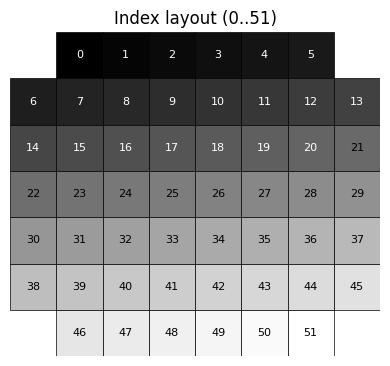

In [10]:

# ==== Visualization: layout preview ====
preview_layout(HARVARD_GF_52_LAYOUT)


In [11]:

# ==== Visualization: a few examples ====
# vmin/vmax you can fix, e.g., vmin=-30, vmax=5 for TDS-like ranges.
vmin, vmax = None, None  # or set to (-30, 5)

save_pngs = True
save_dir = os.path.join(out_dir, 'figs')
Path(save_dir).mkdir(parents=True, exist_ok=True)

for sid, img, gt, pred_scaled in imgs_cache:
    pred = pred_scaled * 1.0   # already scaled back earlier (out = out_scaled*scale)
    save_path = os.path.join(save_dir, f'{sid}.png') if save_pngs else None
    plot_vf_triptych(
        input_img=img, 
        gt_52=gt, 
        pred_52=pred, 
        vmin=vmin, vmax=vmax, 
        save_path=save_path
    )
    if not save_pngs:
        break  # if not saving, display only the first one
print(f'[SAVE] figures -> {save_dir}')


[SAVE] figures -> ./Results_visualization/figs
